# Business Understanding 

CMS rates hospitals in the US on a scale of 1-5 with the objective to make it easier for patients and consumers to compare the quality of hospitals.
The ratings directly influence the choice of the hospital made by consumers and may have a significant impact on the revenue earned by hospitals.
Thus, it is extremely important for hospitals to understand the methodology used by CMS for calculating the ratings so that they can work on
improving the factors that influence them.
 
This project is focused on developing an approach to calculate hospital ratings and using it to identify areas of improvement for
certain hospitals. It will also require a thorough understanding of the rating system developed by CMS.


# Business Problem 

The aim of analysis is to understand the methodology used by CMS for calculating the ratings and identify
the factors influencing the ratings for hospitals, so that they can work on improving the factors that influence them.
Recommend ways to improve the rating for Evanston Hospital to improve their current star rating of 3/5*



# Data Understanding #

The original source of data is `Hospital_Revised_FlatFiles_20161110`
  CSV Files
1.	Readmissions and Deaths - Hospital.csv	                                                readmission.csv
2.	Readmissions and Deaths - Hospital.csv +   Complications - Hospital.csv	                mortality.csv
3.	Healthcare Associated Infections - Hospital.csv +   Complications - Hospital.csv	      safety.csv
4.	HCAHPS - Hospital.csv	                                                                  experience.csv
5.	Outpatient Imaging Efficiency - Hopital.csv	                                            medical.csv
6.	Timely and Effective Care - Hospital.csv	                                              timeliness.csv
7.	Timely and Effective Care - Hospital.csv	                                              effectiveness.csv


# Exploratory Data Analysis 

- Perform the Univariate analysis for all the groups.
- Perform Bi-variate analysis for all the groups.


Modelling 

 Part 1 - Supervised Learning-Based Rating
 Part 2 - Factor analysis and Clustering-Based Rating (Unsupervised)
 Part 3 - Provider analysis - Recommendations for Hospitals

Let us load the data and create the groups as above:
Copied the required raw files to the Groups location.
1. "Readmissions and Deaths - Hospital.csv"
2. "Complications - Hospital.csv"
3. "Healthcare Associated Infections - Hospital.csv"
4. "HCAHPS - Hospital.csv"
5. "Outpatient Imaging Efficiency - Hospital.csv"
6. "Timely and Effective Care - Hospital.csv"



# Data Prepartion, cleaning and Supervised Modelling 
Data set contains 58 excel files, 2 PDF files out of this for this assignment we require 6 files & it has suffix as "_Hospital"

Load the files into dataframes:
1. Load the data - replace Not Available, Not Applicable with NA  (Suffix _Raw dataframes )
2. Split xxxx_rawdata frames into 2 data frames [xxxx_hosp, xxxx_meas)
3. Rename columns - Standardize names across
4. Reorder columns to match all files
5. Standardize the measures- some measures with positive zscores and some measures with negative zscores.
6. Impute the outliers

# Libraries to be used


In [11]:
import os
os.chdir("/Users/eklavya/projects/education/formalEducation/DataScience/DataScienceAssignments/HealthCare/Capstone/src/")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_context('paper')



# Utility functions 

In [12]:
def print_ln():
    print('-' * 80, '\n')


# Function to create a subset of the dataframe
def subset(dataframe, col_name, col_names_list):
    return dataframe.loc[dataframe[col_name].isin(col_names_list)]

# Converts the datatype of a specific column and returns the new dataframe
def func_numeric(df, col_name):
    df[col_name] = df[col_name].astype(float)
    return df

# Renames a column in the dataframe by appending `_score`.
def func_rename(df):
    old_col_names = df.columns.to_list()
    new_col_names = []
    for a_col_name in old_col_names:
        col_name = a_col_name + "_score"
        new_col_names.append(col_name)

    name_pairs = dict(zip(old_col_names, new_col_names))
    df = df.rename(columns=name_pairs)
    return df

# Function to compute the negative zscore value for the dataframe

def negative_zscore(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = - (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df

# Function to compute the positive zscore value for the dataframe
def positive_zscore(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df

# Function to compute the valid subset of a dataframe i.e. reduces outliers via IQR method
def subset_by_iqr(df, column, whisker_width=0):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.00125)
    q3 = df[column].quantile(0.99875)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter][column]


# Driver function for `subset_by_iqr` which treats the outliers in a dataframe
def treat_outliers(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = subset_by_iqr(df, col)
    return df

In [13]:

# Computes the group score of a dataframe after cleaning and doing PCA on the group of measures
def function_group_score(numeric_df, score_name):
    # CMS recommends atleast 3 non-null measures per group
    df = numeric_df.dropna(thresh= 3)
    imputed_df = df.apply(lambda x: x.fillna(x.median()), axis=0)
    pca = IncrementalPCA()
    df_pca = pca.fit_transform(imputed_df)
    df_pca = pd.DataFrame(df_pca, columns= df.columns)
    df_pca.index = df.index
    df_with_weight = df_pca.mean(axis=1)
    df_scores = pd.DataFrame({score_name : df_with_weight})
    return df_scores

## 1. Readmission - Load "Readmissions and Deaths - Hospital.csv" file into read_raw

In [14]:
# Readmissions and deaths 

read_rawdata = pd.read_csv("Readmissions and Deaths - Hospital.csv",
                           encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])

# We will filter only those columns which are needed as per the mentor.
read_meas_list =   ["READM_30_AMI", "READM_30_CABG", "READM_30_COPD", "READM_30_HF", "READM_30_HIP_KNEE", "READM_30_HOSP_WIDE", "READM_30_PN", "READM_30_STK"]

read_hosp = read_rawdata.iloc[:,0:8]


In [15]:
read_hosp = read_hosp.drop_duplicates(keep='first')

In [16]:
read_meas = read_rawdata.iloc[: , [0,9,12]]

In [17]:
# Converting the datatype of Score to a float

read_meas['Score'] = read_meas['Score'].astype(float)


In [18]:
read_meas = read_meas.loc[read_meas['Measure ID'].isin(read_meas_list)]


In [19]:
# Restructure the dataframe to better suit a shape for our analysis
read_meas_score = read_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')


In [20]:
read_meas_score =  func_rename(read_meas_score)

In [21]:
# Let's see what is the sum of all values of a measure, counting NaN as a 0
print(np.nansum(read_meas_score['READM_30_AMI_score'].unique()))

# We will use negative zscore scaling as high readmissions implies the Hospital is not doing well in terms of patient treatment quality.

readmission = negative_zscore(read_meas_score)
print_ln()
readmission


# Outlier treatment: According to the CMS documentation, they've performed the outlier treatment for 
# measures at the 0.125th and the 99.875th percentiles
readmission = treat_outliers(readmission)
readmission

read_master = pd.merge(read_hosp, readmission, on="Provider ID")
read_master.info()
print_ln()
read_master.head()


readmission.to_csv("cleaned_readmission_data_py.csv")


1104.3
-------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 0 to 4817
Data columns (total 16 columns):
Provider ID                 4818 non-null int64
Hospital Name               4818 non-null object
Address                     4818 non-null object
City                        4818 non-null object
State                       4818 non-null object
ZIP Code                    4818 non-null int64
County Name                 4803 non-null object
Phone Number                4818 non-null int64
READM_30_AMI_score          2157 non-null float64
READM_30_CABG_score         1023 non-null float64
READM_30_COPD_score         3640 non-null float64
READM_30_HF_score           3640 non-null float64
READM_30_HIP_KNEE_score     2723 non-null float64
READM_30_HOSP_WIDE_score    4383 non-null float64
READM_30_PN_score           4077 non-null float64
READM_30_STK_score          2601 non-null float64
dtypes: float6

# 2. Mortality - Load 2 Files "Readmissions and Deaths - Hospital.csv + Complications - Hospital.csv" into morality dataframe


In [22]:
mort_rawdata1 = read_rawdata
mort_rawdata1.shape
print_ln()

mort_rawdata2 = pd.read_csv("Complications - Hospital.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
print(mort_rawdata2.shape)
print_ln()

print(mort_rawdata2.columns)
print_ln()

mort_rawdata1.columns == mort_rawdata2.columns

mort_rawdata = pd.concat([mort_rawdata1, mort_rawdata2])
mort_rawdata.shape
print_ln()

mort_rawdata

mort_meas_list =   ["MORT_30_AMI", "MORT_30_CABG", "MORT_30_COPD", "MORT_30_HF", "MORT_30_PN", "MORT_30_STK", "PSI_4_SURG_COMP"]
mort_meas_list
print_ln()

mort_hosp = mort_rawdata.iloc[:,0:8]

mort_hosp = mort_hosp.drop_duplicates(keep='first')
mort_hosp
print_ln()

mort_hosp.dtypes

mort_meas = mort_rawdata.iloc[: , [0,9,12]]
mort_meas.dtypes
print_ln()
mort_meas

mort_meas = mort_meas.loc[mort_meas['Measure ID'].isin(mort_meas_list)]
print(mort_meas)
print_ln()

print(mort_meas.dtypes)
print_ln()

mort_meas = func_numeric(mort_meas, 'Score')
print(mort_meas.dtypes)
print_ln()



mort_meas_score = mort_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
print(mort_meas_score)
print_ln()

mort_meas_score = func_rename(mort_meas_score)
print(mort_meas_score)
print_ln()

print(mort_meas_score.columns)
print_ln()

print(mort_meas_score)
print_ln()

print(mort_meas_score.dtypes)
print_ln()

print(mort_meas_score.info())

mortality = mort_meas_score
print(mortality)
print_ln()

# Mortality indicates the death rate, higher the number worser is the hospital or provider.
# Since it is related to death rate we will use negative z-score formula.
mortality = negative_zscore(mortality)
print(mortality)
print_ln()


mortality = treat_outliers(mortality)
print(mortality)
print_ln()

mort_master = pd.merge(mort_hosp, mortality, on="Provider ID")
print(mort_master.info())
print_ln()
print(mort_master.head())

mortality.to_csv("cleaned_mortality_data_py.csv")

-------------------------------------------------------------------------------- 

(52998, 18)
-------------------------------------------------------------------------------- 

Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Measure Name', 'Measure ID',
       'Compared to National', 'Denominator', 'Score', 'Lower Estimate',
       'Higher Estimate', 'Footnote', 'Measure Start Date',
       'Measure End Date'],
      dtype='object')
-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

       Provider ID       Measure ID  Score
0            10001      MORT_30_AM

## 3. Safety - Load 2 files "Healthcare Associated Infections - Hospital.csv + Complications - Hospital.csv" into safety dataframe


In [23]:
safe_rawdata1 = mort_rawdata
print(safe_rawdata1)
print_ln()

safe_rawdata2 = pd.read_csv("Healthcare Associated Infections - Hospital.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
print(safe_rawdata2)
print_ln()



safe_rawdata1 = safe_rawdata1.iloc[: , [0,1, 2, 3, 4, 5, 6, 7, 9, 12]]
print(safe_rawdata1.columns)
print_ln()

print(safe_rawdata1)
print_ln()

safe_rawdata2 = safe_rawdata2.iloc[: , [0,1, 2, 3, 4, 5, 6, 7, 9, 11]]
print(safe_rawdata2.columns)
print_ln()

print(safe_rawdata2)
print_ln()

safe_rawdata = pd.concat([safe_rawdata1, safe_rawdata2])
safe_meas_list =   ["HAI_1_SIR", "HAI_2_SIR", "HAI_3_SIR", "HAI_4_SIR", "HAI_5_SIR", "HAI_6_SIR", "COMP_HIP_KNEE", "PSI_90_SAFETY"]
safe_hosp = safe_rawdata.iloc[:,0:8]
safe_hosp = safe_hosp.drop_duplicates(keep='first')
safe_hosp
print_ln()
safe_hosp.dtypes


print(safe_rawdata.columns)
print_ln()

safe_meas = safe_rawdata.iloc[: , [0,8,9]]
print(safe_meas)
print_ln()

safe_meas = safe_meas.loc[safe_meas['Measure ID'].isin(safe_meas_list)]
print(safe_meas.dtypes)
print_ln()

safe_meas = func_numeric(safe_meas, 'Score')
print(safe_meas.dtypes)
print_ln()

safe_meas_score = safe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
print(safe_meas_score)
print_ln()

safe_meas_score = func_rename(safe_meas_score)
print(safe_meas_score)
print_ln()

safety = safe_meas_score
print(safety)
print_ln()

# The HAI measures are related to infections contracted by the patients during their stay in the hospital
# we will negative zscore here as well
safety = negative_zscore(safety)
print(safety)
print_ln()

safety = treat_outliers(safety)
print(safety)
print_ln()

safe_master = pd.merge(mort_hosp, safety, on="Provider ID")
print(safe_master)
print_ln()

safety.to_csv("cleaned_safety_data_py.csv")


       Provider ID                     Hospital Name  \
0            10001  SOUTHEAST ALABAMA MEDICAL CENTER   
1            10001  SOUTHEAST ALABAMA MEDICAL CENTER   
2            10001  SOUTHEAST ALABAMA MEDICAL CENTER   
3            10001  SOUTHEAST ALABAMA MEDICAL CENTER   
4            10001  SOUTHEAST ALABAMA MEDICAL CENTER   
...            ...                               ...   
52993       670112      CUMBERLAND SURGICAL HOSPITAL   
52994       670112      CUMBERLAND SURGICAL HOSPITAL   
52995       670112      CUMBERLAND SURGICAL HOSPITAL   
52996       670112      CUMBERLAND SURGICAL HOSPITAL   
52997       670112      CUMBERLAND SURGICAL HOSPITAL   

                         Address         City State  ZIP Code County Name  \
0         1108 ROSS CLARK CIRCLE       DOTHAN    AL     36301     HOUSTON   
1         1108 ROSS CLARK CIRCLE       DOTHAN    AL     36301     HOUSTON   
2         1108 ROSS CLARK CIRCLE       DOTHAN    AL     36301     HOUSTON   
3         1108 ROSS

## 4. Experience - Load file "HCAHPS - Hospital.csv" into experience data rame

In [24]:

expe_rawdata = pd.read_csv("HCAHPS - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])
# expe_rawdata
# expe_rawdata.columns
# print_ln()

expe_new_col_names = {"HCAHPS Question": "Measure Name",
                      "HCAHPS Measure ID": "Measure ID",
                      "HCAHPS Linear Mean Value": "Score"}

expe_rawdata = expe_rawdata.rename(columns=expe_new_col_names)
# expe_rawdata.columns
# print_ln()


expe_meas_list = ["H_CLEAN_LINEAR_SCORE", "H_COMP_1_LINEAR_SCORE", "H_COMP_2_LINEAR_SCORE", "H_COMP_3_LINEAR_SCORE",
                  "H_COMP_4_LINEAR_SCORE", "H_COMP_5_LINEAR_SCORE", "H_COMP_6_LINEAR_SCORE", "H_COMP_7_LINEAR_SCORE",
                  "H_HSP_RATING_LINEAR_SCORE", "H_QUIET_LINEAR_SCORE", "H_RECMND_LINEAR_SCORE"]


expe_hosp = expe_rawdata.iloc[:, 0:8]
# expe_hosp
# print_ln()
# expe_hosp.dtypes


expe_hosp = expe_hosp.drop_duplicates(keep='first')
# expe_hosp
# print_ln()
# expe_hosp.dtypes

expe_meas = expe_rawdata.iloc[:, [0, 8, 15]]
# expe_meas
# print_ln()

expe_meas = expe_meas.loc[expe_meas['Measure ID'].isin(expe_meas_list)]
# expe_meas
# expe_meas.dtypes
# print_ln()

expe_meas = func_numeric(expe_meas, 'Score')
# expe_meas.dtypes
# print_ln()

expe_meas_score = expe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
# expe_meas_score.dtypes
# expe_meas_score
# print_ln()


expe_meas_score = func_rename(expe_meas_score)
# expe_meas_score
# print_ln()


experience = expe_meas_score
# experience
# print_ln()

experience = positive_zscore(experience)
# experience
# print_ln()

experience = treat_outliers(experience)
# experience
# print_ln()

expe_master = pd.merge(expe_hosp, experience, on="Provider ID")
# expe_master
# print_ln()

experience.to_csv("cleaned_experience_data_py.csv")


# 5. Medical - Load file "Outpatient Imaging Efficiency - Hopital.csv" into medical data frame


In [25]:
medi_rawdata = pd.read_csv("Outpatient Imaging Efficiency - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])

medi_meas_list = ["OP_10", "OP_11", "OP_13", "OP_14", "OP_8"]

medi_hosp = medi_rawdata.iloc[:, 0:8]
# medi_hosp
# print_ln()
# medi_hosp.dtypes

medi_hosp = medi_hosp.drop_duplicates(keep='first')
# medi_hosp
# print_ln()
# medi_hosp.dtypes

medi_meas = medi_rawdata.iloc[:, [0, 8, 10]]
# medi_meas
# print_ln()

medi_meas = subset(medi_meas, 'Measure ID', medi_meas_list)
# medi_meas
# medi_meas.dtypes
# print_ln()

medi_meas = func_numeric(medi_meas, 'Score')
# medi_meas.dtypes
# print_ln()


medi_meas_score = medi_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
# medi_meas_score
# print_ln()

medi_meas_score = func_rename(medi_meas_score)
# medi_meas_score
# print_ln()


medical = medi_meas_score
# medical
# print_ln()

medical = negative_zscore(medical)
# medical
# print_ln()

medical = treat_outliers(medical)
# medical
# print_ln()

medi_master = pd.merge(medi_hosp, medical, on="Provider ID")
# medi_master
# print_ln()

medical.to_csv("cleaned_medical_data_py.csv")

# 6. Timeliness - Load file "Timely and Effective Care - Hospital.csv" into timeliness data frame


In [26]:
time_rawdata = pd.read_csv("Timely and Effective Care - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])
# time_rawdata
# print_ln()

time_meas_list = ["ED_1b", "ED_2b", "OP_18b", "OP_20", "OP_21", "OP_3b", "OP_5"]

time_hosp = time_rawdata.iloc[:, 0:8]
# time_hosp
# print_ln()
# time_hosp.dtypes


time_hosp = time_hosp.drop_duplicates(keep='first')
# time_hosp
# print_ln()
# time_hosp.dtypes

time_meas = time_rawdata.iloc[:, [0, 9, 11]]
# time_meas
# print_ln()


time_meas = subset(time_meas, 'Measure ID', time_meas_list)
# time_meas
# time_meas.dtypes
# print_ln()

time_meas = func_numeric(time_meas, 'Score')
# time_meas.dtypes
# print_ln()

time_meas_score = time_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
# time_meas_score
# print_ln()

time_meas_score = func_rename(time_meas_score)
# time_meas_score
# print_ln()

timeliness = time_meas_score
# timeliness
# print_ln()

timeliness = negative_zscore(timeliness)
# timeliness
# print_ln()

timeliness = treat_outliers(timeliness)
# timeliness
# print_ln()

time_master = pd.merge(time_hosp, timeliness, on="Provider ID")
# time_master
# print_ln()

timeliness.to_csv("cleaned_timeliness_data_py.csv")


## 7. Effectiveness - Load file "Timely and Effective Care - Hospital.csv" into timeliness data frame


In [27]:

effe_rawdata = time_rawdata
# effe_rawdata
# print_ln()

effe_meas_list = ["CAC_3", "IMM_2", "IMM_3_OP_27_FAC_ADHPCT", "OP_22", "OP_23", "OP_29", "OP_30", "OP_4", "PC_01", "STK_4", "STK_5", "STK_6", "STK_8", "VTE_1", "VTE_2", "VTE_3", "VTE_5", "VTE_6"]

effe_hosp = effe_rawdata.iloc[:, 0:8]
# effe_hosp
# print_ln()
# effe_hosp.dtypes


effe_hosp = effe_hosp.drop_duplicates(keep='first')
# effe_hosp
# print_ln()
# effe_hosp.dtypes

effe_meas = effe_rawdata.iloc[:, [0, 9, 11]]
# effe_meas
# print_ln()


effe_meas = subset(effe_meas, 'Measure ID', effe_meas_list)
# effe_meas
# effe_meas.dtypes
# print_ln()

effe_meas = func_numeric(effe_meas, 'Score')
# effe_meas.dtypes
# print_ln()

effe_meas_score = effe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
# effe_meas_score
# print_ln()


effe_meas_score = func_rename(effe_meas_score)
# effe_meas_score
# print_ln()

effectiveness = effe_meas_score
# effectiveness
# print_ln()

positive_measures = [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16]
effectiveness.iloc[:, positive_measures] = positive_zscore(effectiveness.iloc[:, positive_measures])
# effectiveness.iloc[:, positive_measures].columns
# print_ln()

negative_measures = [3, 8, 17]
effectiveness.iloc[:, negative_measures] = negative_zscore(effectiveness.iloc[:, negative_measures])
# effectiveness.iloc[:, negative_measures].columns
# print_ln()

effectiveness = treat_outliers(effectiveness)
# effectiveness
# print_ln()

effe_master = pd.merge(effe_hosp, effectiveness, on="Provider ID")
# effe_master
# print_ln()

effectiveness.to_csv("cleaned_effectiveness_data_py.csv")



In [28]:

merge1 = pd.merge(read_master, mort_master)
merge2 = pd.merge(merge1, safe_master)
merge3 = pd.merge(merge2, expe_master)
merge4 = pd.merge(merge3, medi_master)
merge5 = pd.merge(merge4, time_master)
merge6 = pd.merge(merge5, effe_master)

print(merge6.columns.to_list)
print_ln()

print(merge6)
print_ln()

master_data_x = merge6

master_data_x.to_csv("cleaned_master_data_x_py.csv")

<bound method IndexOpsMixin.tolist of Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'READM_30_AMI_score',
       'READM_30_CABG_score', 'READM_30_COPD_score', 'READM_30_HF_score',
       'READM_30_HIP_KNEE_score', 'READM_30_HOSP_WIDE_score',
       'READM_30_PN_score', 'READM_30_STK_score', 'MORT_30_AMI_score',
       'MORT_30_CABG_score', 'MORT_30_COPD_score', 'MORT_30_HF_score',
       'MORT_30_PN_score', 'MORT_30_STK_score', 'PSI_4_SURG_COMP_score',
       'COMP_HIP_KNEE_score', 'HAI_1_SIR_score', 'HAI_2_SIR_score',
       'HAI_3_SIR_score', 'HAI_4_SIR_score', 'HAI_5_SIR_score',
       'HAI_6_SIR_score', 'PSI_90_SAFETY_score', 'H_CLEAN_LINEAR_SCORE_score',
       'H_COMP_1_LINEAR_SCORE_score', 'H_COMP_2_LINEAR_SCORE_score',
       'H_COMP_3_LINEAR_SCORE_score', 'H_COMP_4_LINEAR_SCORE_score',
       'H_COMP_5_LINEAR_SCORE_score', 'H_COMP_6_LINEAR_SCORE_score',
       'H_COMP_7_LINEAR_SCORE_score', 'H_HSP_RATING_LI

-------------------------------------------------------------------------------- 



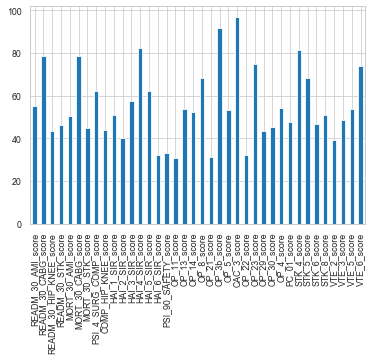

In [29]:
master_data_x = master_data_x.drop_duplicates(keep='first')
master_data_x
print_ln()

master_data_x.isnull().sum()

columns_with_missing_data = round(100 * (master_data_x.isnull().sum() / len(master_data_x.index)), 2)
columns_with_missing_data[columns_with_missing_data > 30].plot(kind='bar')
plt.show()


In [30]:

# np.sum(master_data_x.isnull().sum().to_list())
print_ln()

master_data_x



-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,...,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,...,0.538880,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,...,0.324044,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,...,0.538880,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,...,NaN,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,-0.526375,...,0.538880,-4.929290,NaN,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,-3.876657
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,NaN,...,-2.253994,NaN,NaN,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,NaN
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,-1.236623,...,0.109207,NaN,0.193305,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,0.416331
8,10018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-7.207848,NaN,NaN,NaN,NaN
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,NaN,NaN,...,-1.179812,NaN,-2.207021,-0.915528,-1.392818,0.178342,-0.450362,0.819555,0.635329,NaN


# Load the dependent variable i.e. the `rating` 

In [31]:
hospital_ratings = pd.read_csv("Hospital General Information.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
hospital_ratings.columns
print_ln()
print(hospital_ratings)
print_ln()

master_data_y = hospital_ratings

hospital_ratings[['Hospital overall rating']].isnull().sum()

master_data_y = master_data_y.iloc[:,[0, 12]]

-------------------------------------------------------------------------------- 

      Provider ID                           Hospital Name  \
0           10001        SOUTHEAST ALABAMA MEDICAL CENTER   
1           10005           MARSHALL MEDICAL CENTER SOUTH   
2           10006          ELIZA COFFEE MEMORIAL HOSPITAL   
3           10007                MIZELL MEMORIAL HOSPITAL   
4           10008             CRENSHAW COMMUNITY HOSPITAL   
...           ...                                     ...   
4813       480002  GOV JUAN F LUIS HOSPITAL & MEDICAL CTR   
4814       640001             LBJ TROPICAL MEDICAL CENTER   
4815       650001        GUAM MEMORIAL HOSPITAL AUTHORITY   
4816       650003              GUAM REGIONAL MEDICAL CITY   
4817       660001              COMMONWEALTH HEALTH CENTER   

                                    Address       City State  ZIP Code  \
0                    1108 ROSS CLARK CIRCLE     DOTHAN    AL     36301   
1                2505 U S HIGHWAY 43

In [32]:
print(master_data_y.columns)
print_ln()

master_data = pd.merge(master_data_x, master_data_y, on= "Provider ID")
print(master_data)
print_ln()

Index(['Provider ID', 'Hospital overall rating'], dtype='object')
-------------------------------------------------------------------------------- 

      Provider ID                     Hospital Name  \
0           10001  SOUTHEAST ALABAMA MEDICAL CENTER   
1           10005     MARSHALL MEDICAL CENTER SOUTH   
2           10006    ELIZA COFFEE MEMORIAL HOSPITAL   
3           10007          MIZELL MEMORIAL HOSPITAL   
4           10008       CRENSHAW COMMUNITY HOSPITAL   
...           ...                               ...   
4813       670112      CUMBERLAND SURGICAL HOSPITAL   
4814       640001       LBJ TROPICAL MEDICAL CENTER   
4815       650001  GUAM MEMORIAL HOSPITAL AUTHORITY   
4816       650003        GUAM REGIONAL MEDICAL CITY   
4817       660001        COMMONWEALTH HEALTH CENTER   

                            Address         City State  ZIP Code County Name  \
0            1108 ROSS CLARK CIRCLE       DOTHAN    AL     36301     HOUSTON   
1        2505 U S HIGHWAY 431 

In [33]:

master_data_without_na = master_data[master_data['Hospital overall rating'].notnull()]
master_data_without_na
print_ln()

print(master_data_without_na)

master_data_with_na = master_data[~master_data['Hospital overall rating'].notnull()]
print(master_data_with_na)
print_ln()

np.sum(master_data_without_na.isnull().sum().to_list())



-------------------------------------------------------------------------------- 

      Provider ID                                      Hospital Name  \
0           10001                   SOUTHEAST ALABAMA MEDICAL CENTER   
1           10005                      MARSHALL MEDICAL CENTER SOUTH   
2           10006                     ELIZA COFFEE MEMORIAL HOSPITAL   
3           10007                           MIZELL MEMORIAL HOSPITAL   
4           10008                        CRENSHAW COMMUNITY HOSPITAL   
...           ...                                                ...   
4795       670088  BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...   
4798       670092                         WALNUT HILL MEDICAL CENTER   
4802       670096              BAY AREA REGIONAL MEDICAL CENTER, LLC   
4804       670098                           RESOLUTE HEALTH HOSPITAL   
4815       650001                   GUAM MEMORIAL HOSPITAL AUTHORITY   

                            Address             City

65783

In [34]:
columns_with_missing_data = round(100 * (master_data_without_na.isnull().sum() / len(master_data_without_na.index)), 2)

output = columns_with_missing_data[columns_with_missing_data < 50]
output = list(output.to_dict().keys())
print_ln()

master_data_without_na = master_data_without_na[output]
master_data_without_na

-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.866907,...,0.071075,NaN,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,3.0
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,1.574551,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,3.0
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,0.156930,...,0.328611,NaN,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,2.0
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,0.078174,...,-3.448585,-1.232556,NaN,-3.019716,NaN,0.333841,0.381176,NaN,NaN,3.0
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,0.629471,...,0.714915,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,3.0
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,0.314444,...,-1.688755,NaN,0.538880,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,2.0
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,0.629471,...,0.843683,0.723713,-2.253994,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,3.0
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,1.653308,...,0.843683,NaN,0.109207,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,3.0
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,NaN,-2.363284,...,0.843683,0.545870,-1.179812,-0.915528,-1.392818,0.178342,-0.450362,0.819555,0.635329,2.0
10,10021,DALE MEDICAL CENTER,126 HOSPITAL AVE,OZARK,AL,36360,DALE,3347742601,NaN,0.078174,...,0.414456,0.723713,NaN,NaN,NaN,0.567089,0.547483,NaN,NaN,4.0


In [ ]:
# Impute only relevant numerical columns
master_data_without_na.iloc[ : , 8:] =  master_data_without_na.iloc[ : , 8:].apply(lambda x: x.fillna(x.median()), axis=0)

master_data_without_na

In [ ]:
master_data_without_na.isnull().sum()



In [ ]:
master_data_without_na = master_data_without_na.drop(master_data_without_na.iloc[:, 1:8],  axis = 1)
master_data_without_na['Hospital overall rating'], factors_hospital_overall_rating =  pd.factorize(master_data_without_na['Hospital overall rating'])
cleaned_master_data = master_data_without_na

print_ln()
cleaned_master_data = cleaned_master_data.set_index('Provider ID')

print(cleaned_master_data)

cleaned_master_data.to_csv("cleaned_master_data_py.csv")

In [ ]:
# Exploratory Data Analysis